In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from perovskite_data_analysis.common.storage import GoogleDriveStorage
from perovskite_data_analysis.common.credentials import google_credentials

credentials = google_credentials()
storage = GoogleDriveStorage(credentials)

path = 'perovskite/raw/idc2.csv'
df_base = storage.download_dataframe(path)
df_base

,Ref_ID,Ref_ID_temp,Ref_name_of_person_entering_the_data,Ref_data_entered_by_author,Ref_DOI_number,Ref_lead_author,Ref_publication_date,Ref_journal,Ref_part_of_initial_dataset,Ref_original_filename_data_upload,...,Outdoor_spectral_data_available,Outdoor_link_spectral_data,Outdoor_irradiance_measured,Outdoor_link_irradiance_data,Tolerance factor,TS80,Atemperature,Ahumidity,Alight,TS80m
0,16,16,Adam Hultqvist,False,10.1007/s10118-017-1891-z,Chen et al.,2016/12/29,Chinese Journal of Polymer Science,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,NaN,NaN,NaN,NaN,NaN
1,17,17,Adam Hultqvist,False,10.1007/s10118-017-1891-z,Chen et al.,2016/12/29,Chinese Journal of Polymer Science,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,NaN,NaN,NaN,NaN,NaN
2,26,26,Adam Hultqvist,False,10.1016/j.electacta.2017.12.108,Cai et al.,2017/12/19,Electrochimica Acta,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,220.00000,0.855491,1.70,0.199526,63.839170
3,27,27,Adam Hultqvist,False,10.1016/j.electacta.2017.12.108,Cai et al.,2017/12/19,Electrochimica Acta,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,350.00000,0.855491,1.70,0.199526,101.562315
4,28,28,Adam Hultqvist,False,10.1039/c9ta01893j,Zhang et al.,2019/3/20,Journal of Materials Chemistry A,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.968626,200.00000,0.855491,2.00,1.000000,342.196543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7414,15535,15535,Isaac Gould,False,10.1021/acsami.8b16601,Lin et al.,2018/11/8,ACS Applied Materials & Interfaces,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,72.00000,1.829510,4.00,0.199526,105.130037
7415,15539,15539,Isaac Gould,False,10.1021/acsami.8b16601,Lin et al.,2018/11/8,ACS Applied Materials & Interfaces,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,0.911521,2192.57000,1.829510,1.50,0.199526,1200.546693
7416,10499,10499,Gabriella Stephania Anaya Gonazalez,False,10.1021/acsenergylett.9b00403,Jiang et al.,2019/5/2,ACS Energy Letters,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,NaN,40.00000,43.280500,1.00,0.199526,345.423635
7417,16307,16307,Jacob Vagott,False,10.1039/c7ta01718a,Rakstys et al.,2017/3/29,Journal of Materials Chemistry A,True,Historic dataset on 2020 11 22_v7.xlsx,...,False,NaN,False,NaN,NaN,101.40700,0.855491,1.00,1.000000,86.752812


In [3]:
df = df_base[[
    "Perovskite_composition_a_ions", "Perovskite_composition_a_ions_coefficients", "Perovskite_composition_b_ions", "Perovskite_composition_b_ions_coefficients", "Perovskite_composition_c_ions", "Perovskite_composition_c_ions_coefficients", "Perovskite_composition_short_form", "Perovskite_composition_long_form",
    "Perovskite_composition_inorganic", "Perovskite_band_gap", "Perovskite_deposition_thermal_annealing_temperature",
    "Tolerance factor", "Perovskite_composition_inorganic"
]]
df

,Perovskite_composition_a_ions,Perovskite_composition_a_ions_coefficients,Perovskite_composition_b_ions,Perovskite_composition_b_ions_coefficients,Perovskite_composition_c_ions,Perovskite_composition_c_ions_coefficients,Perovskite_composition_short_form,Perovskite_composition_long_form,Perovskite_composition_inorganic,Perovskite_band_gap,Perovskite_deposition_thermal_annealing_temperature,Tolerance factor,Perovskite_composition_inorganic
0,MA,1,Pb,1,I,3,MAPbI,MAPbI3,False,1.6,70; 100,0.911521,False
1,MA,1,Pb,1,I,3,MAPbI,MAPbI3,False,1.6,70; 100,0.911521,False
2,MA,1,Pb,1,I,3,MAPbI,MAPbI3,False,1.6,100,0.911521,False
3,MA,1,Pb,1,I,3,MAPbI,MAPbI3,False,1.6,100,0.911521,False
4,Cs; FA; MA,0.05; 0.788; 0.162,Pb,1,Br; I,0.51; 2.49,CsFAMAPbBrI,Cs0.05FA0.788MA0.162PbBr0.51I2.49,False,1.59,120,0.968626,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7414,MA,1,Pb,1,I,3,MAPbI,MAPbI3,False,NaN,Unknown,0.911521,False
7415,MA,1,Pb,1,I,3,MAPbI,MAPbI3,False,NaN,Unknown,0.911521,False
7416,BA; FA; MA; PMA,2; 2.4; 0.6,Pb,NaN,I,13,BAFAMAPbI,BA2FA2.4MA0.6PMAPbI13,False,1.58,70; 100,NaN,False
7417,FA; MA,0.85; 0.15,Pb,NaN,Br; I,0.45; 2.55,FAMAPbBrI,FA0.85MA0.15PbBr0.45I2.55,False,NaN,100,NaN,False


### General check - dtypes, nulls and info


In [4]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7419 entries, 0 to 7418
Data columns (total 13 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Perovskite_composition_a_ions                        7416 non-null   object 
 1   Perovskite_composition_a_ions_coefficients           7414 non-null   object 
 2   Perovskite_composition_b_ions                        7417 non-null   object 
 3   Perovskite_composition_b_ions_coefficients           7413 non-null   object 
 4   Perovskite_composition_c_ions                        7417 non-null   object 
 5   Perovskite_composition_c_ions_coefficients           7414 non-null   object 
 6   Perovskite_composition_short_form                    7419 non-null   object 
 7   Perovskite_composition_long_form                     7419 non-null   object 
 8   Perovskite_composition_inorganic                     7419 non-null  

Cols with nulls:  8


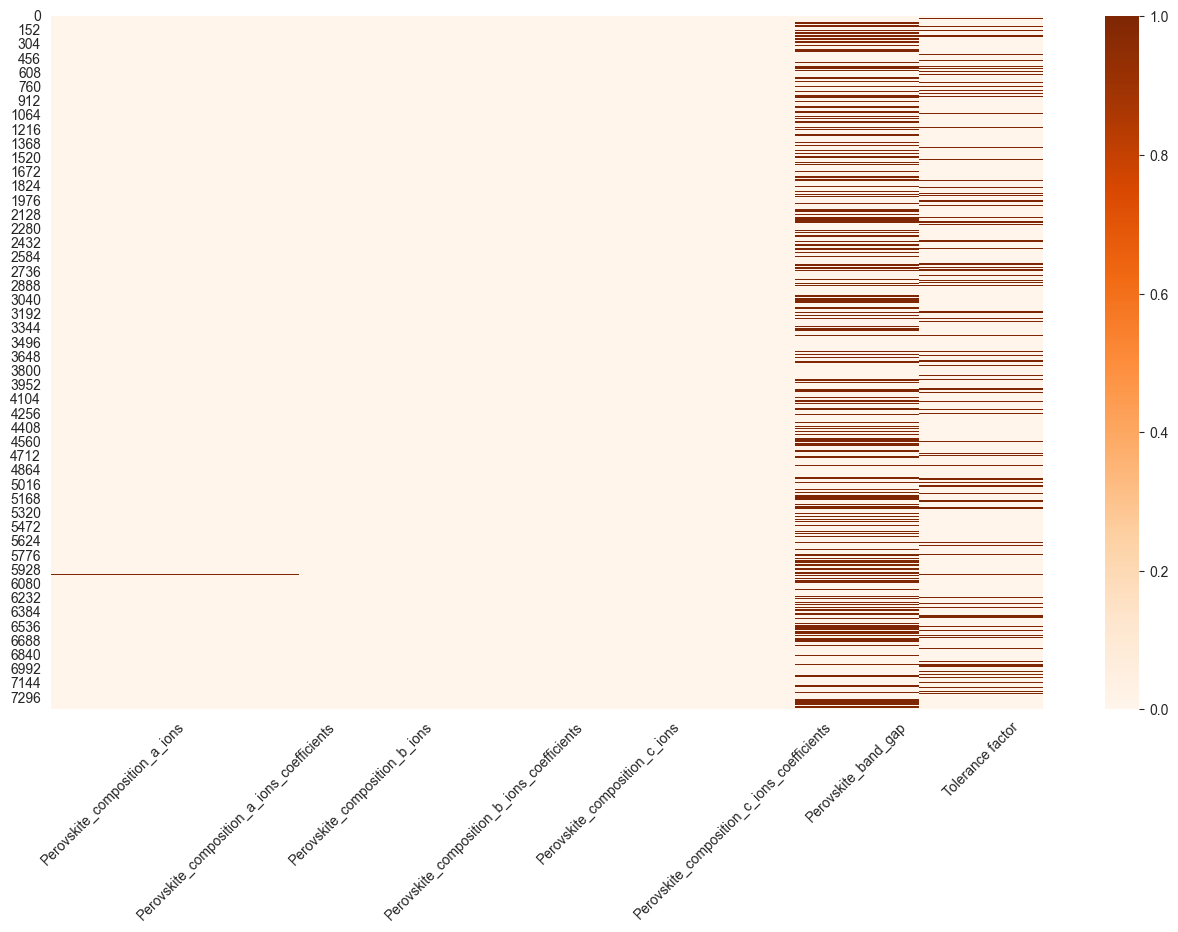

In [5]:
# get total null values
null_cols = [
    col for col in df.columns if df[col].isna().any().any()
]
print("Cols with nulls: ", len(null_cols))
plt.figure(figsize=(16, 9))
sns.heatmap(df[null_cols].isna(), cmap='Oranges', )
plt.xticks(rotation=45)
plt.show()

In [6]:
# filter out non-null band gaps
df = df[~df["Perovskite_band_gap"].isna()]
# check tolerance factor
tolerance_factor_nulls = df["Tolerance factor"].isna().any()
print("Tolerance factor has nulls:", tolerance_factor_nulls)
df.rename(columns={"Tolerance factor": "tolerance_factor"}, inplace=True)

Tolerance factor has nulls: True


/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/1180203098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Tolerance factor": "tolerance_factor"}, inplace=True)


### De-compose ion names to separate columns

In [7]:
df["Perovskite_composition_a_ions"]

0                    MA
1                    MA
2                    MA
3                    MA
4            Cs; FA; MA
             ...       
7407                 MA
7408                 MA
7409             Cs; FA
7410             Cs; FA
7416    BA; FA; MA; PMA
Name: Perovskite_composition_a_ions, Length: 5054, dtype: object

In [8]:
df['Perovskite_composition_b_ions']

0       Pb
1       Pb
2       Pb
3       Pb
4       Pb
        ..
7407    Pb
7408    Pb
7409    Pb
7410    Pb
7416    Pb
Name: Perovskite_composition_b_ions, Length: 5054, dtype: object

In [9]:
df["Perovskite_composition_c_ions"]

0           I
1           I
2           I
3           I
4       Br; I
        ...  
7407        I
7408        I
7409        I
7410        I
7416        I
Name: Perovskite_composition_c_ions, Length: 5054, dtype: object

In [10]:
def decompose_ions(_df: pd.DataFrame, ion_type: str = 'A', coefficient: bool = False):
    """
    Decomposes the site ions in a perovskite composition DataFrame into separate columns.

    Parameters:
    - df: pandas DataFrame containing the perovskite compositions.
    - ion_type: str, the name of the column containing site ions (default: A').

    Returns:
    - pandas DataFrame with new columns A_1, A_2, A_3, etc., containing the decomposed ions.
    """
    ion_type_lower = ion_type.lower()
    col = f'Perovskite_composition_{ion_type_lower}_ions'
    if coefficient:
        col = f'Perovskite_composition_{ion_type_lower}_ions_coefficients'
    _df[f'_{ion_type_lower}_ion_list'] = _df[col].str.split(';').apply(
        lambda x: [item.strip() for item in x if item.strip()] if isinstance(x, list) else []
    )
    max_components = _df[f'_{ion_type_lower}_ion_list'].apply(len).max()
    print(f"Max components for {ion_type}: {max_components}")

    for i in range(max_components):
        col_name = f'{ion_type}_{i + 1}'
        if coefficient:
            col_name = f'{ion_type}_{i + 1}_coef'
        _df[col_name] = _df[f'_{ion_type_lower}_ion_list'].apply(
            lambda x: x[i].strip() if i < len(x) else -1
        )

    _df = _df.drop(columns=[f'_{ion_type_lower}_ion_list'])

    return _df

In [11]:
df = decompose_ions(df, ion_type='A')
df = decompose_ions(df, ion_type='A', coefficient=True)
df = decompose_ions(df, ion_type='B')
df = decompose_ions(df, ion_type='B', coefficient=True)
df = decompose_ions(df, ion_type='C')
df = decompose_ions(df, ion_type='C', coefficient=True)
df.drop(columns=[col for col in df.columns if col.startswith('Perovskite_composition')], inplace=True)

Max components for A: 5
Max components for A: 5


/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/168895642.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[f'_{ion_type_lower}_ion_list'] = _df[col].str.split(';').apply(
/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/168895642.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df[col_name] = _df[f'_{ion_type_lower}_ion_list'].apply(
/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/168895642.py:26: SettingWithCopyWarning: 
A value is trying to be

Max components for B: 3
Max components for B: 3
Max components for C: 3
Max components for C: 3


In [12]:
cols = ["A_1", "A_2", "A_3", "A_4", "A_5", "B_1", "B_2", "B_3", "C_1", "C_2", "C_3"]
coef_cols = [f'{col}_coef' for col in cols]
df[cols + coef_cols]

,A_1,A_2,A_3,A_4,A_5,B_1,B_2,B_3,C_1,C_2,...,A_2_coef,A_3_coef,A_4_coef,A_5_coef,B_1_coef,B_2_coef,B_3_coef,C_1_coef,C_2_coef,C_3_coef
0,MA,-1,-1,-1,-1,Pb,-1,-1,I,-1,...,-1,-1,-1,-1,1,-1,-1,3,-1,-1
1,MA,-1,-1,-1,-1,Pb,-1,-1,I,-1,...,-1,-1,-1,-1,1,-1,-1,3,-1,-1
2,MA,-1,-1,-1,-1,Pb,-1,-1,I,-1,...,-1,-1,-1,-1,1,-1,-1,3,-1,-1
3,MA,-1,-1,-1,-1,Pb,-1,-1,I,-1,...,-1,-1,-1,-1,1,-1,-1,3,-1,-1
4,Cs,FA,MA,-1,-1,Pb,-1,-1,Br,I,...,0.788,0.162,-1,-1,1,-1,-1,0.51,2.49,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7407,MA,-1,-1,-1,-1,Pb,-1,-1,I,-1,...,-1,-1,-1,-1,1,-1,-1,3,-1,-1
7408,MA,-1,-1,-1,-1,Pb,-1,-1,I,-1,...,-1,-1,-1,-1,1,-1,-1,3,-1,-1
7409,Cs,FA,-1,-1,-1,Pb,-1,-1,I,-1,...,0.92,-1,-1,-1,1,-1,-1,3,-1,-1
7410,Cs,FA,-1,-1,-1,Pb,-1,-1,I,-1,...,0.92,-1,-1,-1,1,-1,-1,3,-1,-1


In [13]:
# Function to count ions across all positions for a site
def count_ions(df, site_prefix):
    site_cols = [col for col in df.columns if col.startswith(site_prefix) and "coef" not in col]
    # Stack all columns into a single series and exclude -1
    all_ions = df[site_cols].stack().reset_index(drop=True)
    all_ions = all_ions[all_ions != -1]
    return all_ions.value_counts()


# Get counts for A, B, and C sites
a_ion_counts = count_ions(df, 'A_')
b_ion_counts = count_ions(df, 'B_')
c_ion_counts = count_ions(df, 'C_')

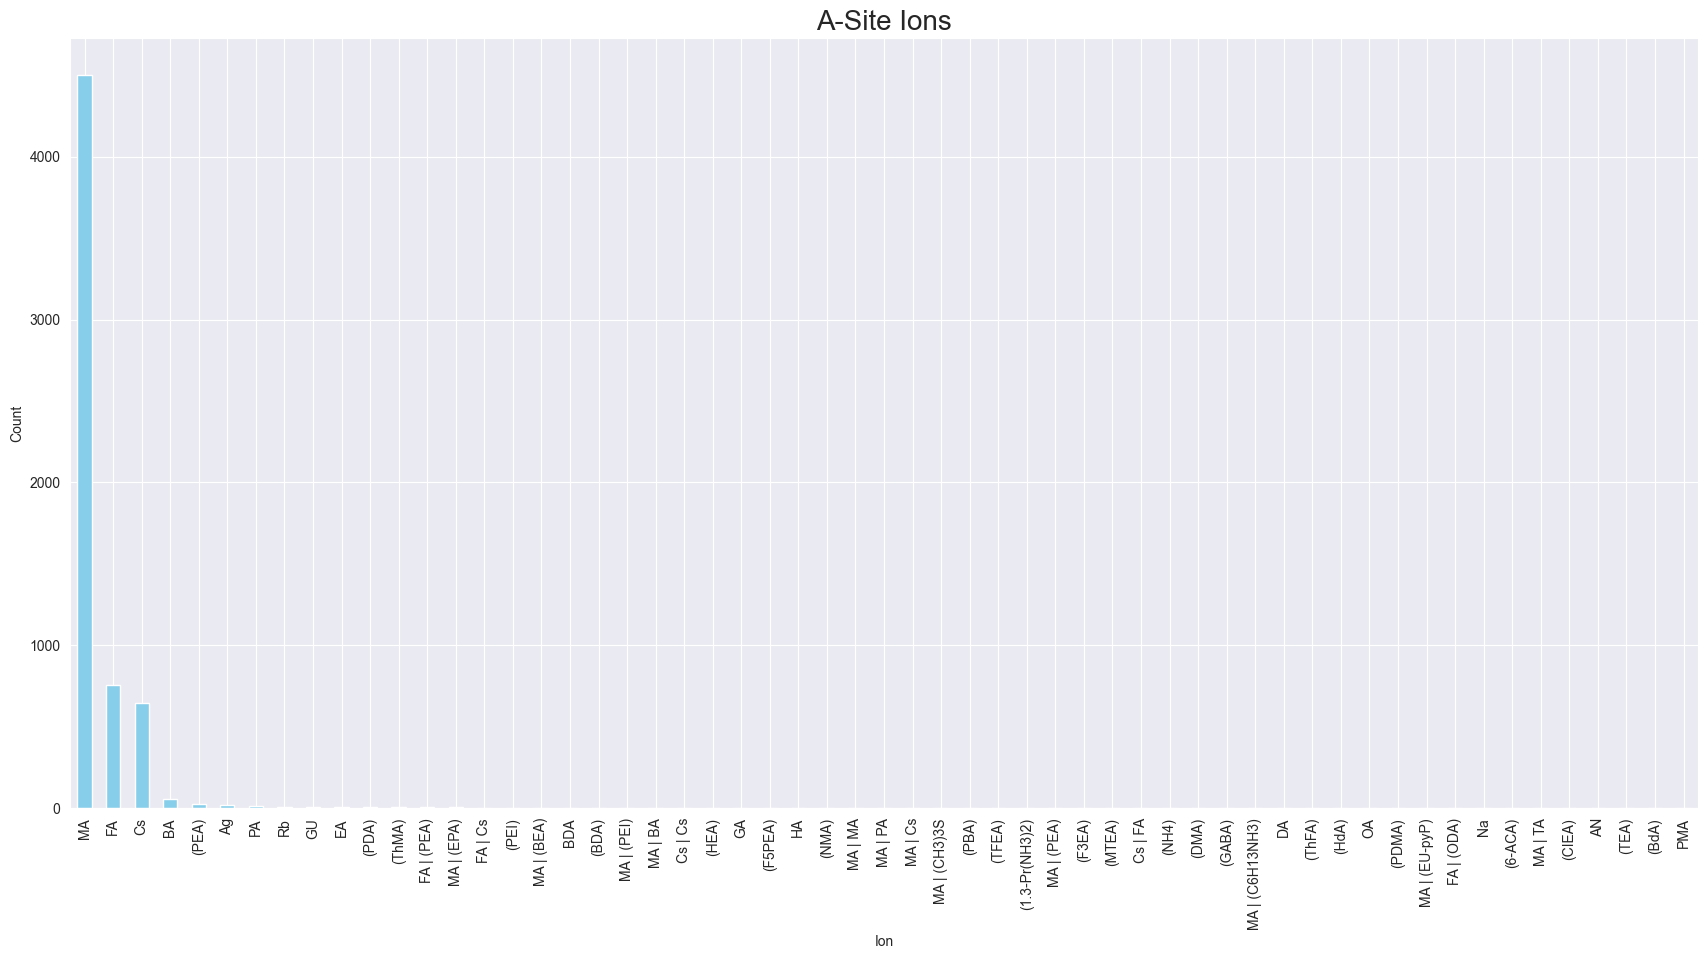

In [14]:
plt.figure(figsize=(21, 10))
a_ion_counts.plot(kind='bar', color='skyblue')
plt.title('A-Site Ions', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Ion')
plt.ylabel('Count')
plt.show()

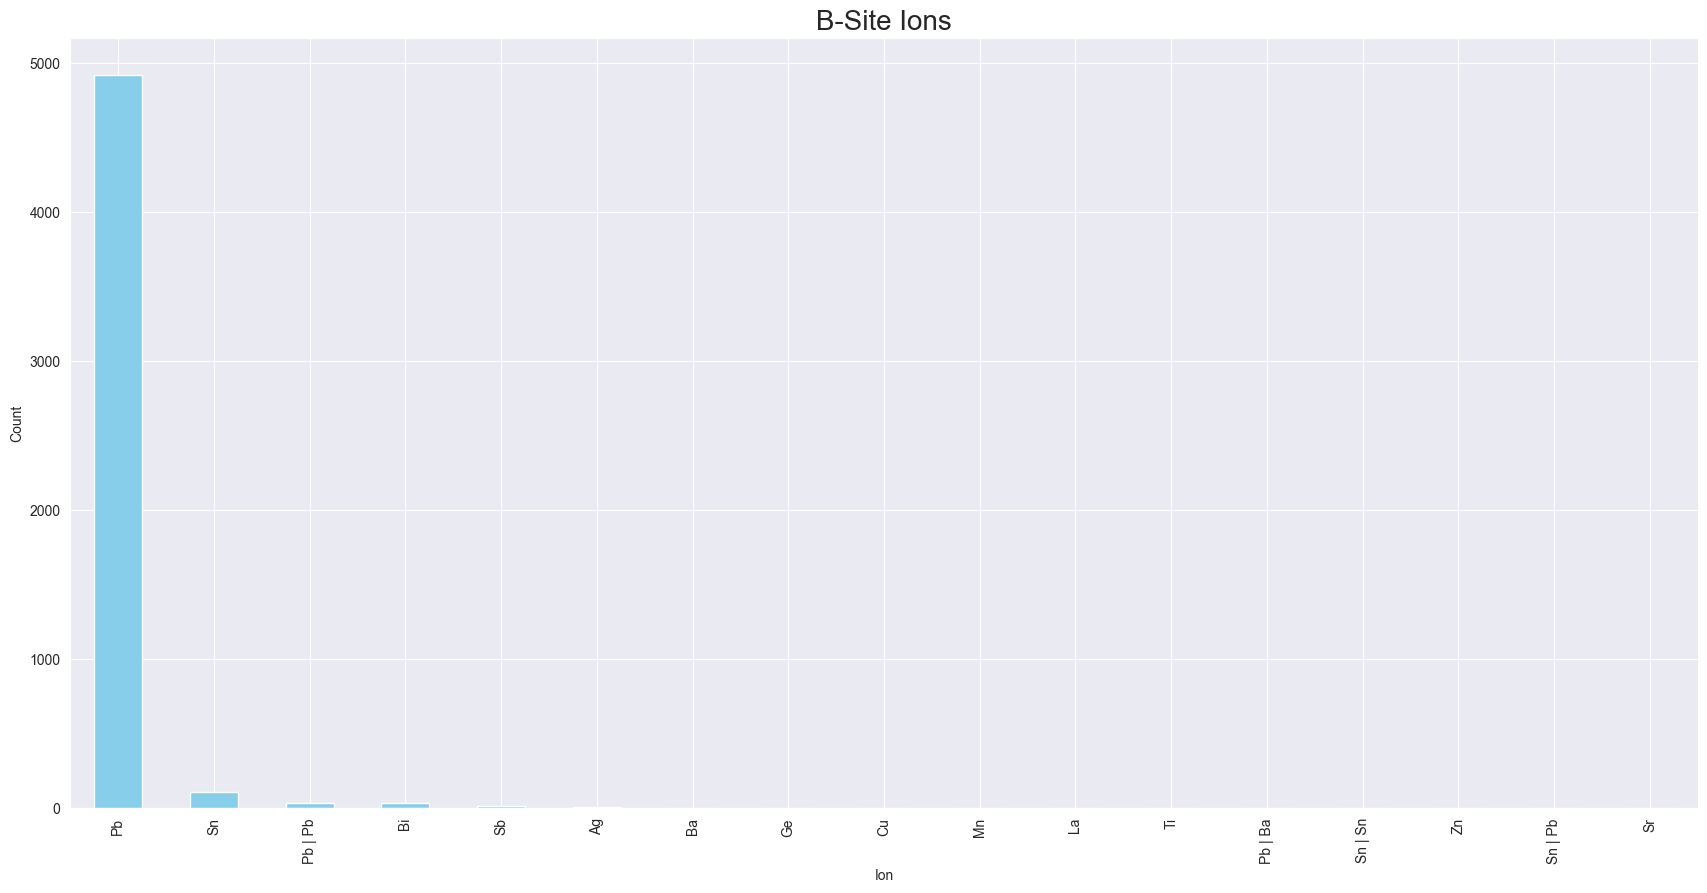

In [15]:
plt.figure(figsize=(21, 10))
b_ion_counts.plot(kind='bar', color='skyblue')
plt.title('B-Site Ions', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Ion')
plt.ylabel('Count')
plt.show()

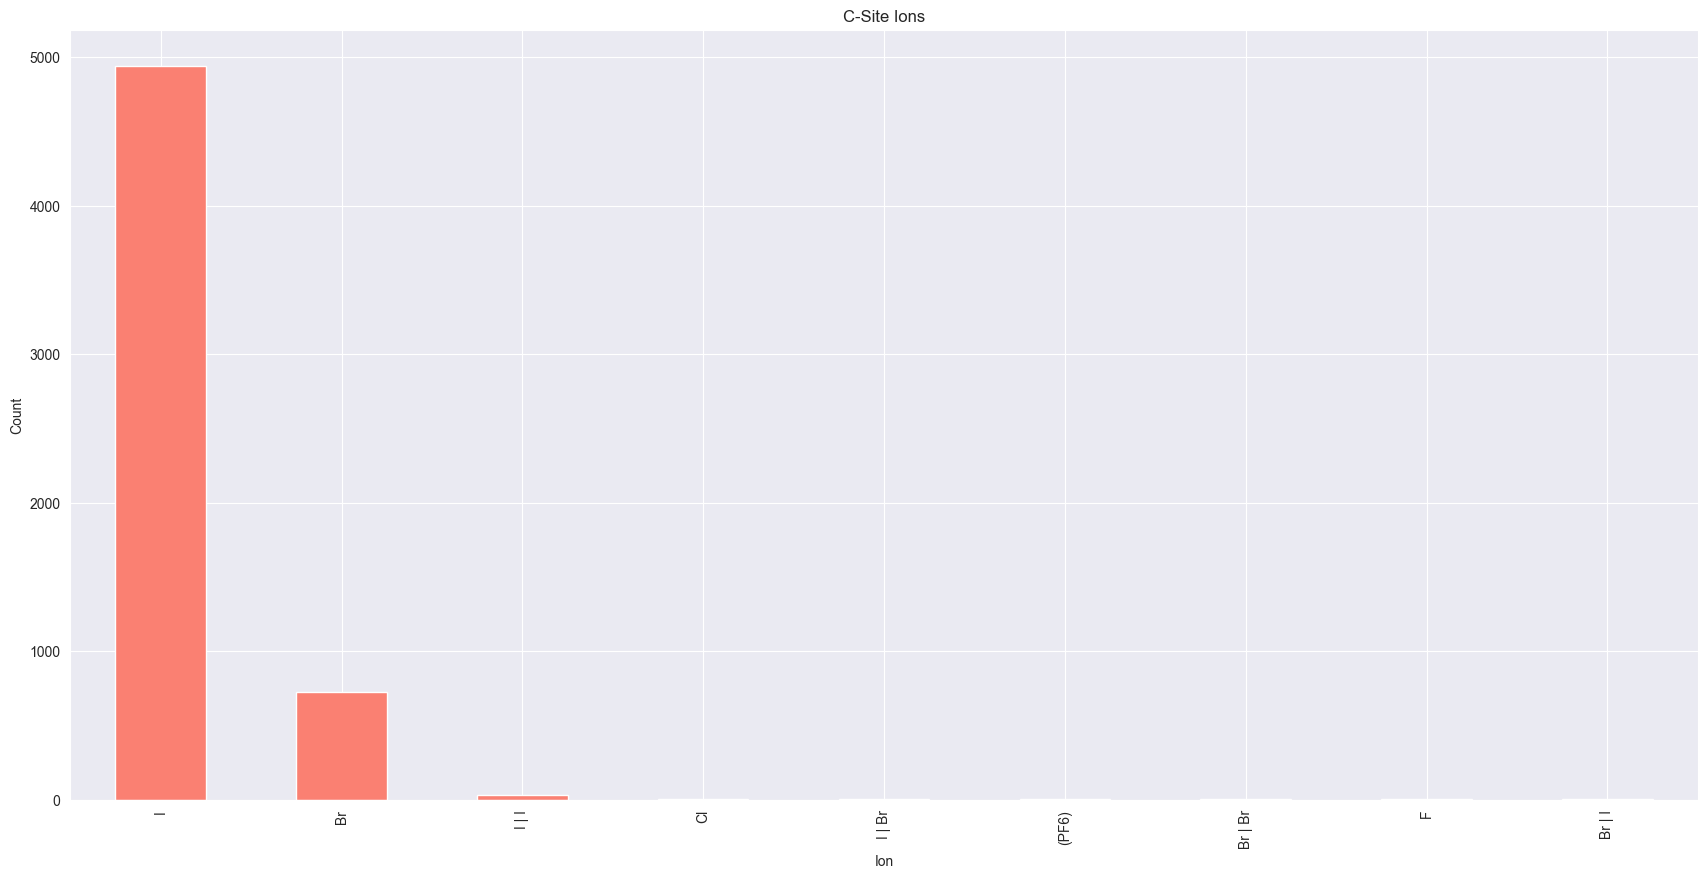

In [16]:
plt.figure(figsize=(21, 10))
c_ion_counts.plot(kind='bar', color='salmon')
plt.title('C-Site Ions')
plt.xticks(rotation=90)
plt.xlabel('Ion')
plt.ylabel('Count')
plt.show()

## Calculate features

In [17]:
from typing import Dict

def create_composition_dict(row: pd.Series) -> Dict[str, Dict[str, float]]:
    composition = {'A': {}, 'B': {}, 'C': {}}

    expected_totals = {'A': 1.0, 'B': 1.0, 'C': 3.0}
    max_slots = {'A': 5, 'B': 3, 'C': 3}

    for ion_prefix in ['A', 'B', 'C']:
        site_dict = {}
        for num in range(1, max_slots[ion_prefix] + 1):
            elem_key = f"{ion_prefix}_{num}"
            coef_key = f"{ion_prefix}_{num}_coef"

            if elem_key not in row:
                continue

            elem = row[elem_key]
            coef = row[coef_key] if coef_key in row else -1

            if elem == -1 or elem == "-1":
                continue
            if isinstance(elem, str) and ("|" in elem or elem.strip() == ""):
                continue

            if isinstance(elem, str):
                elem = elem.replace('(', '').replace(')', '').strip()

            site_dict[elem] = coef
        try:
            site_dict = {k: float(v) for k, v in site_dict.items() if v != 0}
        except ValueError:
           return None

        if not site_dict:
            return None

        if any(coef == -1 for coef in site_dict.values()):
            num_ions = len(site_dict)
            inferred_coef = expected_totals[ion_prefix] / num_ions
            site_dict = {ion: inferred_coef for ion in site_dict}
        else:
            total_coef = sum(site_dict.values())
            if total_coef > 0:
                scaling_factor = expected_totals[ion_prefix] / total_coef
                site_dict = {ion: coef * scaling_factor for ion, coef in site_dict.items()}
        composition[ion_prefix] = site_dict

    return composition

df['composition'] = df.apply(create_composition_dict, axis=1)
df = df[~df.composition.isnull()]
df

,Perovskite_band_gap,Perovskite_deposition_thermal_annealing_temperature,tolerance_factor,A_1,A_2,A_3,A_4,A_5,A_1_coef,A_2_coef,...,B_1_coef,B_2_coef,B_3_coef,C_1,C_2,C_3,C_1_coef,C_2_coef,C_3_coef,composition
0,1.6,70; 100,0.911521,MA,-1,-1,-1,-1,1,-1,...,1,-1,-1,I,-1,-1,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'..."
1,1.6,70; 100,0.911521,MA,-1,-1,-1,-1,1,-1,...,1,-1,-1,I,-1,-1,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'..."
2,1.6,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,1,-1,-1,I,-1,-1,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'..."
3,1.6,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,1,-1,-1,I,-1,-1,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'..."
4,1.59,120,0.968626,Cs,FA,MA,-1,-1,0.05,0.788,...,1,-1,-1,Br,I,-1,0.51,2.49,-1,"{'A': {'Cs': 0.05, 'FA': 0.788, 'MA': 0.162}, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7407,1.63,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,1,-1,-1,I,-1,-1,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'..."
7408,1.63,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,1,-1,-1,I,-1,-1,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'..."
7409,1.51,150,0.972261,Cs,FA,-1,-1,-1,0.08,0.92,...,1,-1,-1,I,-1,-1,3,-1,-1,"{'A': {'Cs': 0.08, 'FA': 0.92}, 'B': {'Pb': 1...."
7410,1.51,150,0.972261,Cs,FA,-1,-1,-1,0.08,0.92,...,1,-1,-1,I,-1,-1,3,-1,-1,"{'A': {'Cs': 0.08, 'FA': 0.92}, 'B': {'Pb': 1...."


In [18]:
# calc structure features
from perovskite_data_analysis.features import structure

df["effective_radii"] = df["composition"].apply(structure.compute_effective_radii)
df = df[~df["effective_radii"].isnull()]
df["r_A"] = df["effective_radii"].apply(lambda x: x[0])
df["r_B"] = df["effective_radii"].apply(lambda x: x[1])
df["r_C"] = df["effective_radii"].apply(lambda x: x[2])
df.drop(columns=["effective_radii"], inplace=True)
# df["octahedral_factor"] = df.apply(
#     lambda row: structure.compute_octahedral_factor(row["r_B"], row["r_C"]),
#     axis=1
# )
df["dimensionality_indicator"] = df["r_A"].apply(structure.compute_dimensionality_indicator)
df["hydrophobicity"] = df["composition"].apply(structure.compute_hydrophobicity_indicator)
df["space_group"] = df.apply(
    lambda row: structure.predict_space_group(row["tolerance_factor"], row["dimensionality_indicator"]),
    axis=1
)

/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/299145646.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["r_A"] = df["effective_radii"].apply(lambda x: x[0])
/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/299145646.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["r_B"] = df["effective_radii"].apply(lambda x: x[1])
/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/299145646.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [19]:
df

,Perovskite_band_gap,Perovskite_deposition_thermal_annealing_temperature,tolerance_factor,A_1,A_2,A_3,A_4,A_5,A_1_coef,A_2_coef,...,C_1_coef,C_2_coef,C_3_coef,composition,r_A,r_B,r_C,dimensionality_indicator,hydrophobicity,space_group
0,1.6,70; 100,0.911521,MA,-1,-1,-1,-1,1,-1,...,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m
1,1.6,70; 100,0.911521,MA,-1,-1,-1,-1,1,-1,...,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m
2,1.6,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m
3,1.6,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m
4,1.59,120,0.968626,Cs,FA,MA,-1,-1,0.05,0.788,...,0.51,2.49,-1,"{'A': {'Cs': 0.05, 'FA': 0.788, 'MA': 0.162}, ...",2.42868,1.190,2.1592,0,0,Pm3m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7378,1.38,60; 120,0.813951,Cs,-1,-1,-1,-1,1,-1,...,3,-1,-1,"{'A': {'Cs': 1.0}, 'B': {'Pb': 0.6, 'Sn': 0.4}...",1.67000,1.154,2.2000,0,0,I4/mcm
7407,1.63,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m
7408,1.63,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,3,-1,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m
7409,1.51,150,0.972261,Cs,FA,-1,-1,-1,0.08,0.92,...,3,-1,-1,"{'A': {'Cs': 0.08, 'FA': 0.92}, 'B': {'Pb': 1....",2.46120,1.190,2.2000,0,0,Pm3m


In [20]:
# charge calc
from perovskite_data_analysis.features import factors

df["octahedral_factor"] = df.apply(
    lambda row: factors.compute_octahedral_factor(row["r_B"], row["r_C"]), axis=1
)
df["tolerance_factor"] = df.apply(
    lambda row: factors.compute_tolerance_factor(row["r_A"], row["r_B"], row["r_C"]), axis=1
)


/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/1664909822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["octahedral_factor"] = df.apply(
/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/1664909822.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tolerance_factor"] = df.apply(


In [21]:
from perovskite_data_analysis.features import charge

df["charge_balance"] = df["composition"].apply(charge.compute_charge_balance)
df

/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/3091814393.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["charge_balance"] = df["composition"].apply(charge.compute_charge_balance)


,Perovskite_band_gap,Perovskite_deposition_thermal_annealing_temperature,tolerance_factor,A_1,A_2,A_3,A_4,A_5,A_1_coef,A_2_coef,...,C_3_coef,composition,r_A,r_B,r_C,dimensionality_indicator,hydrophobicity,space_group,octahedral_factor,charge_balance
0,1.6,70; 100,0.911521,MA,-1,-1,-1,-1,1,-1,...,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m,0.540909,0.0
1,1.6,70; 100,0.911521,MA,-1,-1,-1,-1,1,-1,...,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m,0.540909,0.0
2,1.6,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m,0.540909,0.0
3,1.6,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m,0.540909,0.0
4,1.59,120,0.968626,Cs,FA,MA,-1,-1,0.05,0.788,...,-1,"{'A': {'Cs': 0.05, 'FA': 0.788, 'MA': 0.162}, ...",2.42868,1.190,2.1592,0,0,Pm3m,0.551130,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7378,1.38,60; 120,0.815892,Cs,-1,-1,-1,-1,1,-1,...,-1,"{'A': {'Cs': 1.0}, 'B': {'Pb': 0.6, 'Sn': 0.4}...",1.67000,1.154,2.2000,0,0,I4/mcm,0.524545,0.0
7407,1.63,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m,0.540909,0.0
7408,1.63,100,0.911521,MA,-1,-1,-1,-1,1,-1,...,-1,"{'A': {'MA': 1.0}, 'B': {'Pb': 1.0}, 'C': {'I'...",2.17000,1.190,2.2000,0,0,Pm3m,0.540909,0.0
7409,1.51,150,0.972261,Cs,FA,-1,-1,-1,0.08,0.92,...,-1,"{'A': {'Cs': 0.08, 'FA': 0.92}, 'B': {'Pb': 1....",2.46120,1.190,2.2000,0,0,Pm3m,0.540909,0.0


In [23]:
df.drop(columns=["Perovskite_deposition_thermal_annealing_temperature", "composition"], inplace=True)

/var/folders/tp/56v792jn3_d0vk3wx0vp0jnc0000gn/T/ipykernel_71212/587519951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Perovskite_deposition_thermal_annealing_temperature", "composition"], inplace=True)


In [27]:
df.to_csv("data.csv")